In [2]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

from portfolio_stats import PortfolioStats

from workflow.tools.utils import set_plot_style

set_plot_style()

In [3]:
kwargs = {
    "index_col": 0,
    "parse_dates": True
}

# Mean variance portfolio returns
mv_rets = pd.read_csv("workflow/data/returns/mv_rets.csv", **kwargs)
mv_rets.columns = [f"MV_{col}" for col in mv_rets]

# Leveraged neural network portfolio returns
nn_lev_rets = pd.read_csv("workflow/data/returns/nn_lev_rets.csv", **kwargs)
nn_lev_rets.columns = [f"{col}_LVGD" for col in nn_lev_rets]

# No leverage neural network portfolio returns
nn_unlev_rets = pd.read_csv("workflow/data/returns/nn_unlev_rets.csv", **kwargs)
nn_unlev_rets.columns = [f"{col}_UNLVGD" for col in nn_unlev_rets]

# Combine dataframes
port_rets = pd.concat([mv_rets, nn_lev_rets, nn_unlev_rets], axis=1)

# Descending order of return performance
port_rets.head()

,MV_LVGD,MV_EW,MV_UNLVGD,FCN_LVGD,CNN_LVGD,LSTM_LVGD,FCN_UNLVGD,CNN_UNLVGD,LSTM_UNLVGD
Date,,,,,,,,,
2013-10-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-10-15,0.007328,0.034462,0.001836,0.137849,0.141298,0.016483,-0.000468,0.149428,0.003144
2013-10-16,0.000366,-0.052995,0.000084,-0.211982,-0.219630,-0.022926,0.004297,-0.237855,-0.004907
2013-10-17,0.005101,-0.020635,0.001271,-0.082540,-0.077193,-0.003172,0.002793,-0.087320,0.000966
2013-10-18,0.007164,-0.004681,0.001793,-0.018723,-0.024452,0.002235,0.001672,-0.033186,0.002700


In [4]:
# Get stock market returns
bm_rets = pd.read_csv("workflow/data/features.csv", **kwargs)["STOCKS_RET"].reindex(port_rets.index)
bm_rets.name = "STOCK_MARKET"

# Combine dataframes
backtest = pd.concat([port_rets, bm_rets], axis=1)

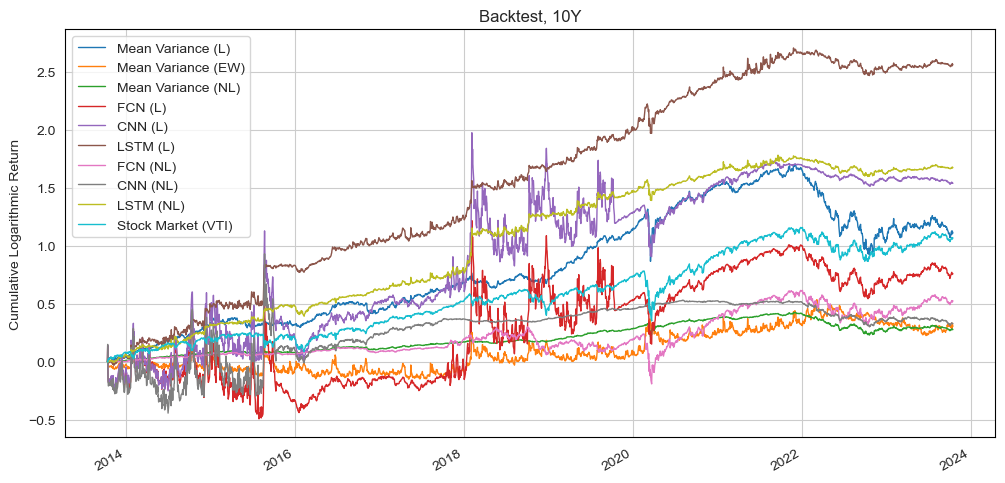

In [5]:
names = [
    "Mean Variance (L)",
    "Mean Variance (EW)",
    "Mean Variance (NL)",
    "FCN (L)",
    "CNN (L)",
    "LSTM (L)",
    "FCN (NL)",
    "CNN (NL)",
    "LSTM (NL)",
    "Stock Market (VTI)"
]

# Plot returns
backtest.cumsum().plot(figsize=(12, 6))

plt.legend(names)
plt.title("Backtest, 10Y")
plt.ylabel("Cumulative Logarithmic Return")
plt.xlabel("")
plt.show()

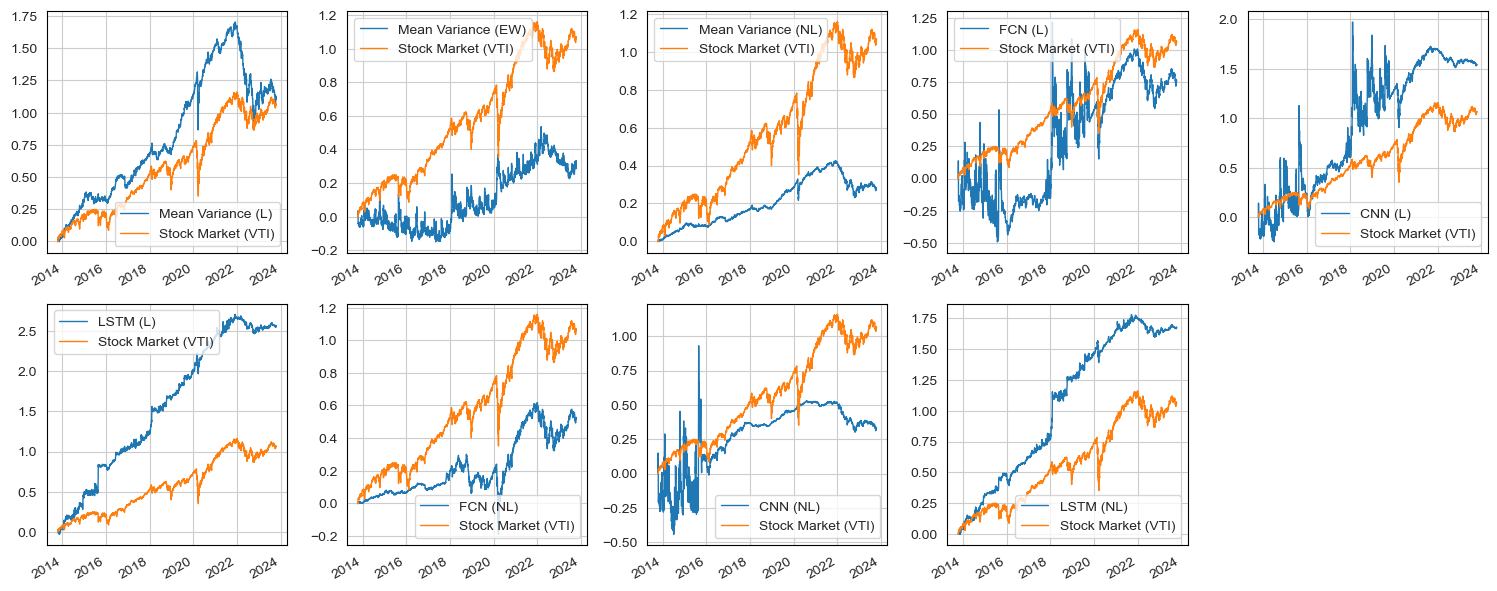

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, (col, ax) in enumerate(zip(backtest.columns, axes)):
    if col != "STOCK_MARKET":
        if names[i] != "Stock Market (VTI)":
            backtest[col].cumsum().plot(ax=ax)
            backtest["STOCK_MARKET"].cumsum().plot(ax=ax)
            ax.legend([names[i], "Stock Market (VTI)"])
            ax.set_xlabel("")

axes[-1].axis("off")
plt.tight_layout()

In [7]:
backtest_stats = PortfolioStats(backtest, log=True).info
backtest_stats.index = names

backtest_stats = backtest_stats.sort_values(by="SHARPE", ascending=False)

backtest_stats["CUMU_EXC_RET"] = backtest_stats["CUMU_RET"] - backtest_stats.loc["Stock Market (VTI)", "CUMU_RET"]
backtest_stats["ALPHA"] = backtest_stats["ANN_RET"] - backtest_stats.loc["Stock Market (VTI)", "ANN_RET"]

backtest_stats = backtest_stats.applymap(lambda x: f"{x:,.3f}")
backtest_stats.loc["Stock Market (VTI)", ["CUMU_EXC_RET", "ALPHA"]] = ["-", "-"]
backtest_stats

,SHARPE,CUMU_RET,ANN_RET,ANN_VOL,MAX_DD,CUMU_EXC_RET,ALPHA
LSTM (L),1.109,2.561,0.256,0.231,-0.254,1.493,0.149
LSTM (NL),1.044,1.674,0.167,0.160,-0.183,0.606,0.061
Stock Market (VTI),0.597,1.068,0.107,0.179,-0.431,-,-
Mean Variance (NL),0.561,0.278,0.028,0.049,-0.196,-0.791,-0.079
Mean Variance (L),0.561,1.110,0.111,0.198,-0.784,0.042,0.004
FCN (NL),0.326,0.525,0.053,0.161,-0.492,-0.543,-0.054
CNN (L),0.196,1.539,0.154,0.784,-1.148,0.471,0.047
Mean Variance (EW),0.111,0.305,0.030,0.275,-0.310,-0.764,-0.076
FCN (L),0.098,0.759,0.076,0.779,-1.149,-0.309,-0.031
CNN (NL),0.059,0.330,0.033,0.555,-0.942,-0.738,-0.074


In [61]:
with open("workflow/data/weights/lev_weights.pkl", "rb") as f:
    lev_weights = pickle.load(f)

with open("workflow/data/weights/unlev_weights.pkl", "rb") as f:
    unlev_weights = pickle.load(f)

lstm_lev_weights = lev_weights["LSTM"]
lstm_unlev_weights = unlev_weights["LSTM"]

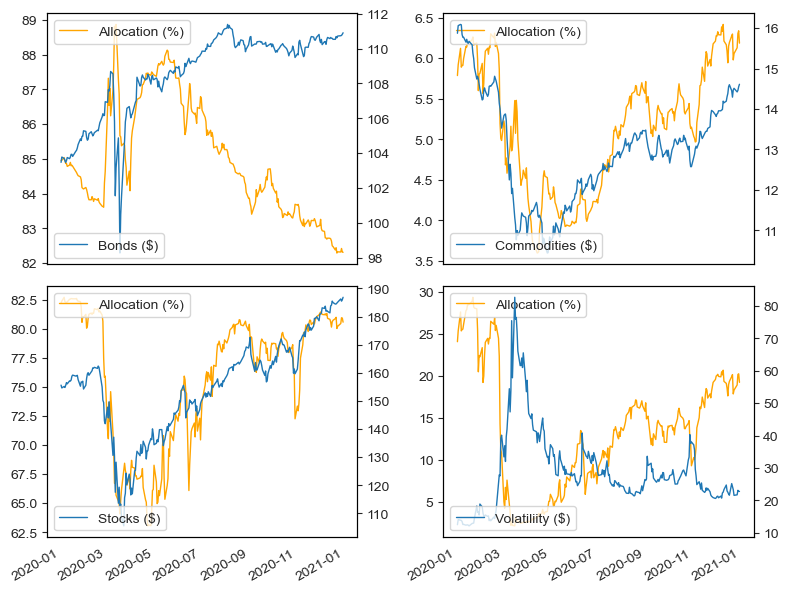

In [70]:
prices = pd.read_csv("workflow/data/index_prices.csv", **kwargs)

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
axes = axes.flatten()

start = "2020-01"
end = "2020-12"

for i, col in enumerate(lstm_lev_weights.columns):
    ax = axes[i]
    ax2 = ax.twinx()

    (lstm_lev_weights[col].loc[start:end] * 100).plot(ax=ax, grid=False, color="orange")
    prices[col].loc[start:end].plot(ax=ax2, grid=False)
    ax.legend(["Allocation (%)"], loc="upper left")
    ax.set_xlabel("")
    ax2.legend([col.title() + " ($)"], loc="lower left")

plt.tight_layout()

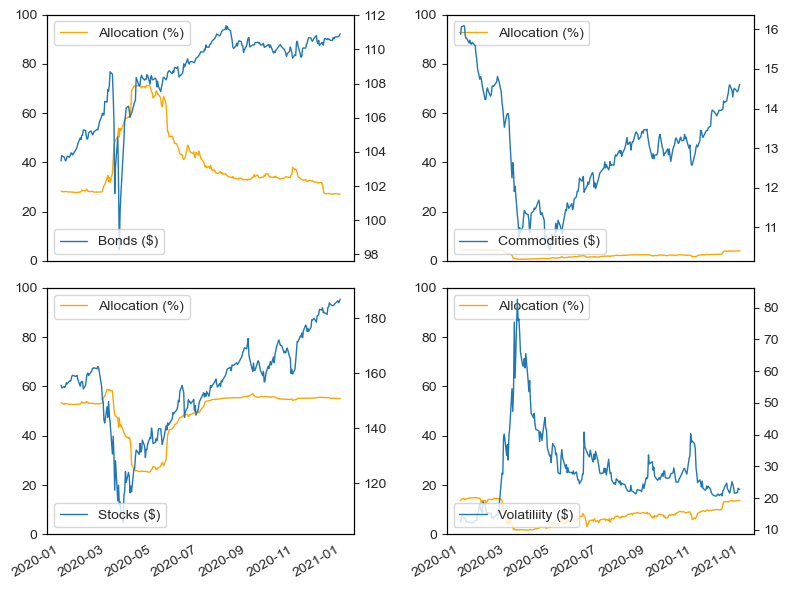

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True)
axes = axes.flatten()

for i, col in enumerate(lstm_unlev_weights.columns):
    ax = axes[i]
    ax2 = ax.twinx()

    (lstm_unlev_weights[col].loc[start:end] * 100).plot(ax=ax, grid=False, color="orange")
    prices[col].loc[start:end].plot(ax=ax2, grid=False)
    ax.legend(["Allocation (%)"], loc="upper left")
    ax.set_xlabel("")
    ax2.legend([col.title() + " ($)"], loc="lower left")

plt.tight_layout()